# Part (f) – Time-Series Clustering

Steps:
1. Load stock time-series data (default: Plotly finance dataset).
2. Create return-based feature vectors for each symbol.
3. Cluster time series using K-Means.
4. Visualize clustered series and mean pattern per cluster.


Assignment done by :- Dev Mulchandani

In [5]:
# @title Load dataset (upload / URL / Kaggle)
import pandas as pd
import zipfile
from pathlib import Path

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DEFAULT_URL = "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv"  # You can change this to another CSV URL

print("How do you want to load the dataset?")
print("1 = upload CSV file manually")
print("2 = download from URL (uses DEFAULT_URL above)")
print("3 = download from Kaggle (you must provide kaggle.json & dataset name)")
choice = input("Enter 1, 2, or 3: ").strip()

if choice == "1":
    if not IN_COLAB:
        raise RuntimeError("Manual upload only works in Google Colab.")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    df = pd.read_csv(fname)
    print("Loaded:", fname, "shape:", df.shape)
elif choice == "2":
    if not DEFAULT_URL:
        raise ValueError("DEFAULT_URL is empty. Please set it to a valid CSV URL or choose another option.")
    df = pd.read_csv(DEFAULT_URL)
    print("Loaded from URL. Shape:", df.shape)
elif choice == "3":
    import os, subprocess

    if IN_COLAB:
        from google.colab import files  # type: ignore
        print("Please upload your kaggle.json file (from your Kaggle account).")
        uploaded = files.upload()
        kaggle_path = Path("~/.kaggle").expanduser()
        kaggle_path.mkdir(parents=True, exist_ok=True)
        for fn in uploaded:
            Path(fn).replace(kaggle_path / "kaggle.json")
        os.chmod(kaggle_path / "kaggle.json", 0o600)

    # Install kaggle CLI
    import sys
    !pip -q install kaggle

    DATASET_SLUG = input("Enter Kaggle dataset slug (e.g. 'uciml/iris'): ").strip()

    # Download entire dataset (may contain multiple files)
    !kaggle datasets download -d $DATASET_SLUG -p kaggle_data

    # Unzip everything
    kaggle_dir = Path("kaggle_data")
    kaggle_dir.mkdir(exist_ok=True)
    for zpath in kaggle_dir.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(kaggle_dir)

    csv_files = list(kaggle_dir.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files found in Kaggle dataset; please inspect kaggle_data/ manually.")
    csv_path = csv_files[0]
    print("Using CSV:", csv_path)
    df = pd.read_csv(csv_path)
    print("Loaded from Kaggle. Shape:", df.shape)
else:
    raise ValueError("Invalid choice. Please run this cell again.")

df.head()


How do you want to load the dataset?
1 = upload CSV file manually
2 = download from URL (uses DEFAULT_URL above)
3 = download from Kaggle (you must provide kaggle.json & dataset name)
Enter 1, 2, or 3: 1


Saving new_timeseries.csv to new_timeseries.csv
Loaded: new_timeseries.csv shape: (200, 11)


,Date,STOCK1.Close,STOCK2.Close,STOCK3.Close,STOCK4.Close,STOCK5.Close,STOCK6.Close,STOCK7.Close,STOCK8.Close,STOCK9.Close,STOCK10.Close
0,2020-01-01,100.154149,100.229805,99.820907,100.181372,101.268247,99.090056,99.339959,99.560272,99.556804,101.881789
1,2020-01-02,100.340684,98.286149,98.431575,99.601155,101.847684,98.418164,100.127222,99.029804,98.443431,103.436515
2,2020-01-03,100.642266,99.422532,97.750786,97.784273,100.924380,98.106476,101.597840,98.476269,97.354574,103.144811
3,2020-01-04,102.230904,99.031156,97.084078,97.921730,100.868769,97.103764,101.640103,98.162761,99.095275,102.634748
4,2020-01-05,103.817205,98.844659,97.514192,98.183903,99.904956,97.187244,101.813939,97.205917,99.998863,101.755556


In [6]:
# @title Prepare multivariate time series per symbol
import pandas as pd
import numpy as np

df_ts = df.copy()
price_cols = [c for c in df_ts.columns if c.endswith(".Close")]

if "Date" in df_ts.columns and price_cols:
    symbols = [c.split(".")[0] for c in price_cols]
    print("Detected symbols:", sorted(set(symbols)))
    prices = df_ts[price_cols]
    prices.columns = [c.split(".")[0] for c in price_cols]
    prices.index = pd.to_datetime(df_ts["Date"])
else:
    raise ValueError("Expected a finance-style dataset with 'Date' and '*.Close' columns.")

returns = prices.pct_change().dropna()
features = returns.T.values
print("Feature matrix shape (symbols x time):", features.shape)


Detected symbols: ['STOCK1', 'STOCK10', 'STOCK2', 'STOCK3', 'STOCK4', 'STOCK5', 'STOCK6', 'STOCK7', 'STOCK8', 'STOCK9']
Feature matrix shape (symbols x time): (10, 199)


In [7]:
# @title Cluster time series with K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(features)

score = silhouette_score(features, labels)
print(f"Silhouette score: {score:.3f}")

for cluster_id in range(k):
    members = prices.columns[labels == cluster_id]
    print(f"Cluster {cluster_id}: {list(members)}")


Silhouette score: 0.009
Cluster 0: ['STOCK1', 'STOCK2', 'STOCK4', 'STOCK6', 'STOCK7', 'STOCK8', 'STOCK9']
Cluster 1: ['STOCK3']
Cluster 2: ['STOCK5', 'STOCK10']


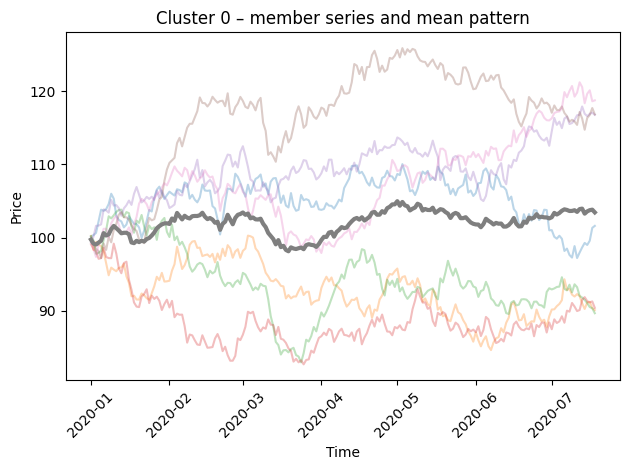

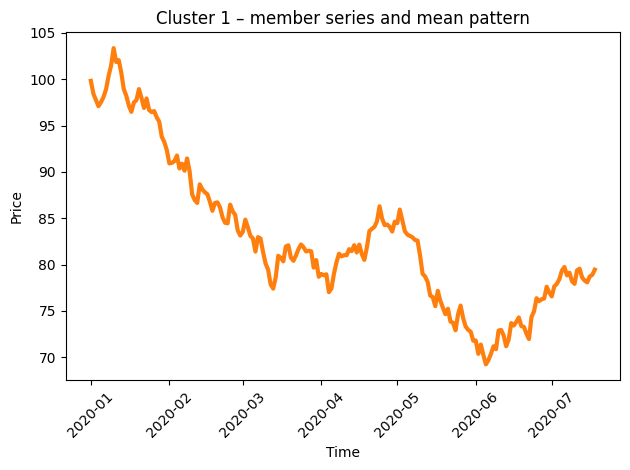

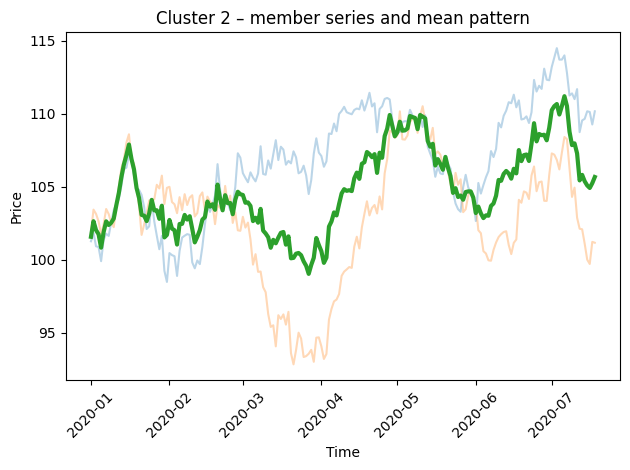

In [8]:
# @title Plot clusters and mean series
import matplotlib.pyplot as plt

k = len(set(labels))
for cluster_id in range(k):
    members = prices.columns[labels == cluster_id]
    if len(members) == 0:
        continue
    mean_series = prices[members].mean(axis=1)
    plt.figure()
    for sym in members:
        plt.plot(prices.index, prices[sym], alpha=0.3)
    plt.plot(prices.index, mean_series, linewidth=3)
    plt.title(f"Cluster {cluster_id} – member series and mean pattern")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
